<a href="https://colab.research.google.com/github/AINetServices/Langgraph-end-to-end-projects/blob/main/chart_genertaor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install langgraph
%pip install langchain_groq
%pip install langchain_community
%pip install python-dotenv
%pip install TavilySearchResults
%pip install langchain_experimental


ERROR: Could not find a version that satisfies the requirement TavilySearchResults (from versions: none)
ERROR: No matching distribution found for TavilySearchResults


In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()


# --- agent node wrapper ---
import functools
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_groq import ChatGroq # or replace with your LLM integration
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from langgraph.prebuilt import ToolNode
from langchain_community.tools.tavily_search import TavilySearchResults
from google.colab import userdata

# --- config & LLM ---
GROQ_KEY = userdata.get('GROQ_API_KEY')
TAVILY_KEY = userdata.get('TAVILY_API_KEY')
# Use your LLM of choice here (ChatGroq shown as example)
llm = ChatGroq(model="llama-3.3-70b-versatile", temperature=0, api_key=GROQ_KEY)


# --- tools ---
search_tool = TavilySearchResults(max_results=3, tavily_api_key=TAVILY_KEY)
repl = PythonREPL()


@tool
def python_repl(code: str):
    """Runs python code and returns the output."""
    try:
        return repl.run(code)
    except Exception as e:
        return f"Error: {e}"


# --- helper to create agent prompt/agent binding ---
def create_agent(llm, tools, system_message: str):
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a helpful AI assistant. Use provided tools when needed. Available tools: {tool_names}. {system_message}"),
        MessagesPlaceholder(variable_name="messages"),
    ])
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([t.name for t in tools]))
    return prompt | llm.bind_tools(tools)


# --- agent node wrapper ---
from typing import Annotated, Sequence, TypedDict
import operator
from langchain_core.messages import BaseMessage
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str


def agent_node(state, agent, name):
    try:
        result = agent.invoke(state)
        if isinstance(result, ToolMessage):
            pass
        else:
            result = AIMessage(**result.model_dump(exclude={"type", "name"}), name=name)
        return {"messages": [result], "sender": name}
    except Exception as e:
        return {"messages": [AIMessage(content=f"Error in {name}: {e}", name=name)], "sender": name}


# Create agents
research_agent = create_agent(llm, [search_tool], system_message="Search for data about UK GDP. Once you find the UK's GDP in 2023, provide a FINAL ANSWER with the GDP value.")
chart_agent = create_agent(llm, [python_repl], system_message="Create Python code to chart data with matplotlib.")


research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")
chart_node = functools.partial(agent_node, agent=chart_agent, name="ChartGenerator")


# Tool node
tool_node = ToolNode([search_tool, python_repl])


# Router function
from typing import Literal


def router(state) -> Literal["call_tool", "__end__", "continue"]:
    messages = state.get("messages", [])
    if not messages:
        return "continue"
    last = messages[-1]
    if hasattr(last, 'tool_calls') and getattr(last, 'tool_calls'):
        return "call_tool"
    if "FINAL ANSWER" in getattr(last, 'content', ""):
        return "__end__"
    return "continue"


# Build graph
workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("ChartGenerator", chart_node)
workflow.add_node("call_tool", tool_node)


workflow.add_conditional_edges("Researcher", router, {"continue": "ChartGenerator", "call_tool": "call_tool", "__end__": END})
workflow.add_conditional_edges("ChartGenerator", router, {"continue": "Researcher", "call_tool": "call_tool", "__end__": END})
workflow.add_conditional_edges("call_tool", lambda s: s["sender"], {"Researcher": "Researcher", "ChartGenerator": "ChartGenerator"})
workflow.add_edge(START, "Researcher")


graph = workflow.compile()


if __name__ == "__main__":
    initial_state = {"messages": [HumanMessage(content="Search the web and tell me the UK's GDP in 2023.")]}
    print("Starting graph stream...a")
    for evt in graph.stream(initial_state, {"recursion_limit": 10}):
        print(evt)
    print("---")

Starting graph stream...
{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'syb03zr11', 'function': {'arguments': '{"query":"UK GDP 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 344, 'total_tokens': 366, 'completion_time': 0.058830451, 'prompt_time': 0.028714726, 'queue_time': 0.183900193, 'total_time': 0.087545177}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_155ab82e98', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run--04f2f59c-5be5-4a0f-863b-a9c337a495f4-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'UK GDP 2023'}, 'id': 'syb03zr11', 'type': 'tool_call'}], usage_metadata={'input_tokens': 344, 'output_tokens': 22, 'total_tokens': 366})], 'sender': 'Researcher'}}


{'call_tool': {'messages': [ToolMessage(content='[{"title": "U.K. GDP | Historical Chart & Data", "url": "https://www.macrotrends.net/global-metrics/countries/gbr/united-kingdom/gdp-gross-domestic-product", "content": "## U.K. GDP\\n\\nPopulation Economy Trade Health Education Development Labor Force Environment Crime Immigration Other\\n\\nGDP GDP Growth Rate GDP Per Capita Debt to GDP Inflation Rate Manufacturing GNI GNI Per Capita GNP\\n\\n##### U.K. GDP for 2023 was 3.381 trillion US dollars, a 8.57% increase from 2022.", "score": 0.9441409}, {"title": "GDP quarterly national accounts, UK: January to March 2025", "url": "https://www.ons.gov.uk/economy/grossdomesticproductgdp/bulletins/quarterlynationalaccounts/januarytomarch2025", "content": "| Relating to Period | Q1 2023 | Q2 2023 | Q3 2023 | Q4 2023 | Q1 2024 | Q2 2024 | Q3 2024 | Q4 2024 | Q1 2025 |\\n| May 2023 | 0.1 |  |  |  |  |  |  |\\n| Jun 2023 | 0.1 |  |  |  |  |  |  |\\n| Aug 2023 | 0.1 | 0.2 |  |  |  |  |  |\\n| Sep 20

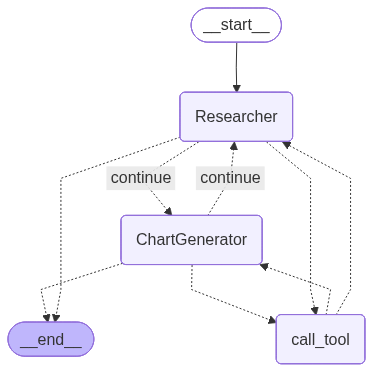

In [ ]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

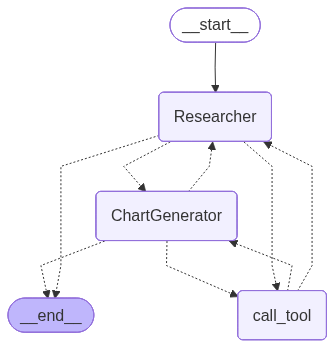

In [ ]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

Creating bar chart for: HOW REAL ESTATE NOW IN US
Starting graph execution...

--- Step 1 (Researcher) ---
Content: 



--- Step 2 (call_tool) ---
Content: [{"title": "Emerging Trends in Real Estate® 2025 - PwC", "url": "https://www.pwc.com/us/en/industries/financial-services/asset-wealth-management/real-estate/emerging-trends-in-real-estate.html", "content": "#### 2025 US Markets to Watch: Overall Real Estate Prospect Rank\n\n## Explore\n\n### Top real estate industry trends for 2025\n\n## Related content\n\n### Next in asset and wealth management 2025\n\nAWM leaders can no longer delay their transformation efforts as socio-economic, investment and funding disruption sweep aside old ways of doing business.\n\n### Roadmap for a REIT IPO or conversion [...] The story surrounding the top real estate markets is the same, but the leaderboard is changing. The Sunbelt is still home to the top markets, however Nashville and Phoenix, last year’s leaders, are falling several rungs while Dallas/Fort Worth ascends to the top spot. Florida is the comeback kid, with two cities placing among the top five markets. [.


--- Step 3 (Researcher) ---
Content: DATA_FOUND: The current US real estate market trends show that the seasonally adjusted annual sales rate is at 4.01 million, with a 2.0% monthly growth and 0.8% year-over-year increase. New home sales decreased by 0.6% between June and July, but by 8.2% compared to last year. The West region saw an 11.7% month-over-month increase in sales, while the Midwest posted a 4.9% year-over-year gain. Elevated home equity levels continue to perpetuate a high percentage of equity-rich mortgages, with over 46% of mortgaged homes being equity-rich during the first quarter of 2025. The US housing market is expected to remain largely frozen through 2025, with some growth expected at a subdued pace of 3% or less. Existing home sales and inventory remain low, with inventory rising 0.7% month-over-month to 1.37 million and existing home sales rising 3.4% month-over-month to 3.96 million in October 2024.



--- Step 4 (ChartGenerator) ---
Content:  Housing market supply remains tight nationally, with new homes for sale at 481K, the highest level since 2007, and speculative homes for sale at 385K, the highest since 2008.


CHART_CREATED


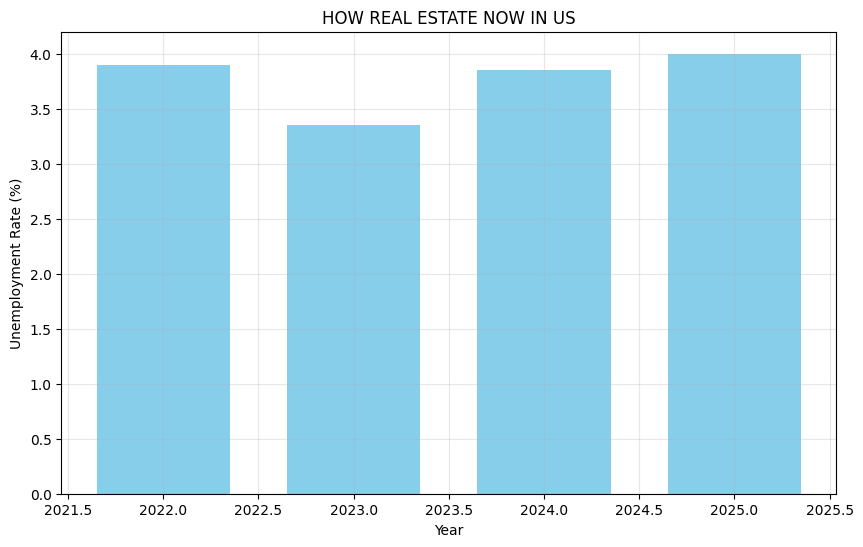


--- Step 5 (call_tool) ---
Content: Chart created and displayed successfully. Chart saved to chart.png

--- Process Complete ---

Displaying the generated chart:


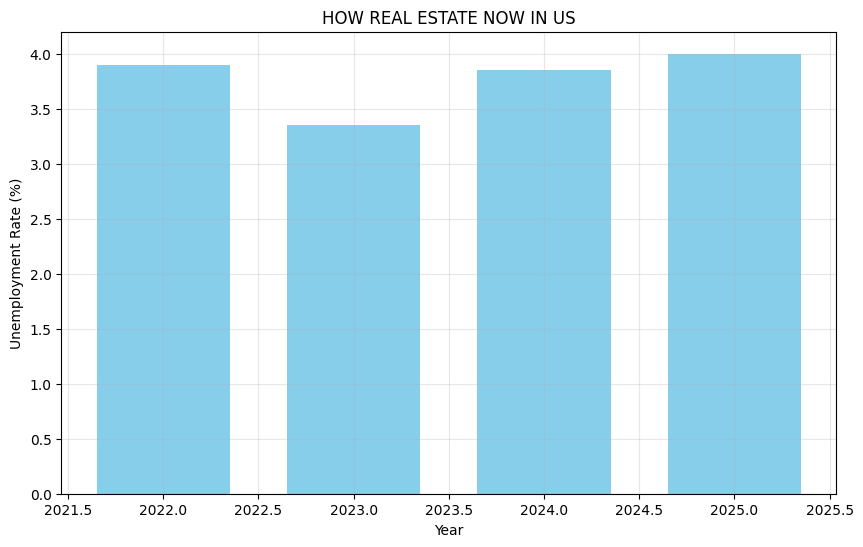

In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()

# --- agent node wrapper ---
import functools
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from langgraph.prebuilt import ToolNode
from langchain_community.tools.tavily_search import TavilySearchResults
from google.colab import userdata
from IPython.display import Image, display
import matplotlib.pyplot as plt
import re

# --- config & LLM ---
GROQ_KEY = userdata.get('GROQ-API-KEY')
TAVILY_KEY = userdata.get('TAVILY_API_KEY')
llm = ChatGroq(model="llama-3.3-70b-versatile", temperature=0, api_key=GROQ_KEY)

# --- tools ---
search_tool = TavilySearchResults(max_results=3, tavily_api_key=TAVILY_KEY)
repl = PythonREPL()

@tool
def python_repl(code: str):
    """Runs python code and returns the output, saving plots as images."""
    try:
        # Execute the code
        exec(code, globals())

        # Save and display plot if one exists
        if plt.get_fignums():
            plt.savefig("chart.png", dpi=100, bbox_inches='tight')
            plt.close()  # Close the figure to avoid display issues
            # Display the chart in Colab
            display(Image(filename="chart.png"))
            return "Chart created and displayed successfully. Chart saved to chart.png"
        return "Code executed successfully without generating a plot."
    except Exception as e:
        return f"Error: {e}"

# --- helper to create agent prompt/agent binding ---
def create_agent(llm, tools, system_message: str):
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a helpful AI assistant. Use provided tools when needed. Available tools: {tool_names}. {system_message}"),
        MessagesPlaceholder(variable_name="messages"),
    ])
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([t.name for t in tools]))
    return prompt | llm.bind_tools(tools)

# --- agent node wrapper ---
from typing import Annotated, Sequence, TypedDict
import operator
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str
    user_query: str = None
    chart_type: str = None
    data: str = None

def agent_node(state, agent, name):
    try:
        result = agent.invoke(state)
        if isinstance(result, ToolMessage):
            pass
        else:
            result = AIMessage(**result.model_dump(exclude={"type", "name"}), name=name)
        return {"messages": [result], "sender": name}
    except Exception as e:
        return {"messages": [AIMessage(content=f"Error in {name}: {e}", name=name)], "sender": name}

def extract_chart_type(query):
    """Extract chart type from user query"""
    chart_types = ["bar chart", "line chart", "pie chart", "scatter plot", "histogram"]
    detected_type = None

    for ctype in chart_types:
        if ctype in query.lower():
            detected_type = ctype
            break

    # Default to bar chart if no specific type mentioned
    if not detected_type:
        detected_type = "bar chart"

    return detected_type

def extract_data_from_research(content):
    """Extract structured data from research agent response"""
    # Look for unemployment rate patterns
    unemployment_data = {}

    # Pattern for "2022: 3.6% (December), 3.9% (September), 4.2% (June)"
    year_pattern = r'(\d{4}):\s*([\d\.]+)%\s*\([^)]+\)'
    year_matches = re.findall(year_pattern, content)

    for year, rate in year_matches:
        if year not in unemployment_data:
            unemployment_data[year] = []
        unemployment_data[year].append(float(rate))

    # Pattern for "3.3% (March)" without year
    rate_pattern = r'([\d\.]+)%\s*\(([^)]+)\)'
    rate_matches = re.findall(rate_pattern, content)

    for rate, month in rate_matches:
        if "unknown" not in unemployment_data:
            unemployment_data["unknown"] = []
        unemployment_data["unknown"].append((month, float(rate)))

    return unemployment_data

# Create agents with dynamic instructions
def create_research_agent(user_query):
    return create_agent(llm, [search_tool],
        system_message=f"Search for data as requested by the user: '{user_query}'. Find the relevant numerical values and provide the exact data. Once you have the data, say 'DATA_FOUND: [summary of data with values]'.")

def create_chart_agent(user_query, chart_type, research_data):
    # Extract and structure the data
    structured_data = extract_data_from_research(research_data)

    system_message = f"""Create Python code to create a {chart_type} based on unemployment data. Use matplotlib.

    Based on the research data, here's what was found: {structured_data}

    IMPORTANT: You MUST generate complete, runnable Python code that:
    1. Imports matplotlib.pyplot as plt
    2. Creates a {chart_type} with proper data organization
    3. Sets title, x-label, y-label based on: '{user_query}'
    4. Uses plt.savefig('chart.png') to save the chart
    5. Returns 'CHART_CREATED' after the code

    For unemployment data over multiple years, a line chart would be appropriate to show trends.

    Example format for line chart:
    import matplotlib.pyplot as plt
    years = [2022, 2023, 2024, 2025]
    # Use average or representative values for each year
    unemployment_rates = [3.9, 3.35, 3.85, 4.0]
    plt.figure(figsize=(10, 6))
    plt.plot(years, unemployment_rates, marker='o', linestyle='-')
    plt.title('Unemployment Rate in NSW (2022-2025)')
    plt.xlabel('Year')
    plt.ylabel('Unemployment Rate (%)')
    plt.grid(True, alpha=0.3)
    plt.savefig('chart.png')
    print('CHART_CREATED')

    Make sure your code is properly formatted and complete."""

    return create_agent(llm, [python_repl], system_message=system_message)

# Tool node
tool_node = ToolNode([search_tool, python_repl])

# Router function
from typing import Literal

def router(state) -> Literal["call_tool", "__end__", "ChartGenerator", "Researcher"]:
    messages = state.get("messages", [])
    if not messages:
        return "Researcher"

    last_message = messages[-1]
    content = getattr(last_message, 'content', '')
    sender = state.get("sender", "")

    # If we just called a tool, return to the sender
    if hasattr(last_message, 'tool_calls') and getattr(last_message, 'tool_calls'):
        return "call_tool"

    # If we're coming from a tool call, return to the original agent
    if isinstance(last_message, ToolMessage):
        return sender

    # Check for completion conditions
    if "DATA_FOUND:" in content:
        return "ChartGenerator"  # Move to chart creation
    elif "CHART_CREATED" in content or "chart.png" in content:
        return "__end__"  # End the process
    elif "Error:" in content:
        return "__end__"  # End on error

    # Default routing based on current sender
    if sender == "Researcher":
        return "ChartGenerator"
    else:
        return "Researcher"

# Build graph
workflow = StateGraph(AgentState)

def research_node(state):
    agent = create_research_agent(state.get("user_query", ""))
    return agent_node(state, agent, "Researcher")

def chart_node(state):
    # Find the research data from previous messages
    research_data = ""
    for msg in state.get("messages", []):
        if hasattr(msg, 'content') and "DATA_FOUND:" in msg.content:
            research_data = msg.content
            break

    agent = create_chart_agent(
        state.get("user_query", ""),
        state.get("chart_type", "line chart"),
        research_data
    )
    return agent_node(state, agent, "ChartGenerator")

workflow.add_node("Researcher", research_node)
workflow.add_node("ChartGenerator", chart_node)
workflow.add_node("call_tool", tool_node)

# Simplified edges
workflow.add_conditional_edges(
    "Researcher",
    router,
    {"ChartGenerator": "ChartGenerator", "call_tool": "call_tool", "__end__": END}
)

workflow.add_conditional_edges(
    "ChartGenerator",
    router,
    {"Researcher": "Researcher", "call_tool": "call_tool", "__end__": END}
)

workflow.add_conditional_edges(
    "call_tool",
    lambda state: state["sender"],  # Return to the agent that called the tool
    {"Researcher": "Researcher", "ChartGenerator": "ChartGenerator"}
)

workflow.add_edge(START, "Researcher")

graph = workflow.compile()

def create_chart_for_question(question):
    """Main function to create a chart based on any question"""
    # Extract chart type from question
    chart_type = extract_chart_type(question)

    initial_state = {
        "messages": [HumanMessage(content=question)],
        "sender": "User",
        "user_query": question,
        "chart_type": chart_type
    }

    print(f"Creating {chart_type} for: {question}")
    print("Starting graph execution...")

    # Run the graph with stream to see progress
    for step, output in enumerate(graph.stream(initial_state, {"recursion_limit": 15})):
        node_name = list(output.keys())[0]
        message = output[node_name]["messages"][-1]
        print(f"\n--- Step {step + 1} ({node_name}) ---")
        print(f"Content: {message.content}")

        # Break early if we see completion or error
        if any(phrase in getattr(message, 'content', '') for phrase in ["CHART_CREATED", "chart.png", "Error:"]):
            break

    print("\n--- Process Complete ---")

    # Display the chart if created
    if os.path.exists("chart.png"):
        print("\nDisplaying the generated chart:")
        display(Image(filename="chart.png"))
    else:
        print("No chart was created during the process.")

# Example usage:
if __name__ == "__main__":
    # You can replace this with any question about data visualization
    question = "HOW REAL ESTATE NOW IN US"
    create_chart_for_question(question)

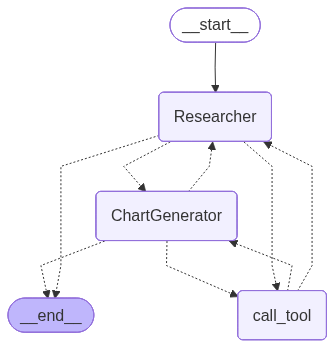

In [ ]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)